In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from cellpose import models, io, plot
from tifffile import imread
import os
import tifffile
from cellpose import plot
import shapely.geometry as geometry
from shapely.geometry import Polygon
from shapely.affinity import translate, scale
from shapely.errors import TopologicalError
from rasterio import features
from sklearn.metrics import jaccard_score
from skimage.measure import regionprops_table


# Set up plotting aesthetics
sns.set(style='whitegrid')
%matplotlib inline

Loading and inspecting the morphology image is a foundational step in the analysis. Understanding the image's dimensions helps guide downstream processing, including selecting channels or slices for segmentation and defining an ROI if needed.

In [2]:
image_data_path = 'data/xenium_2.0.0_io/morphology.ome.tif'
image = tifffile.imread(image_data_path)
print(f"Image shape: {image.shape}")

Image shape: (11, 17098, 51187)


we retrieve and inspect the metadata embedded within the morphology image file. Opening the file with `tifffile.TiffFile` allows us to access not only the pixel data but also any associated metadata stored in OME (Open Microscopy Environment) format. By using a context manager (`with` statement), we ensure that the file is properly handled, meaning it will close automatically once we’re done, helping to avoid potential file-handling errors.

The OME metadata contains crucial information about the image acquisition settings. Extracting it with `ome_metadata = tif.ome_metadata` provides us with details about the microscope settings, pixel size, and other experimental parameters. This metadata appears in XML format, which is printed for review. Examining this data is essential to understand the spatial resolution of the image, enabling us to relate image coordinates to real-world units, such as micrometers. Knowing these specifics is key for aligning segmentation results accurately with the spatial features observed in the morphology image.

In [3]:
with tifffile.TiffFile(image_data_path) as tif:
    ome_metadata = tif.ome_metadata
    print(ome_metadata)

<OME xmlns="http://www.openmicroscopy.org/Schemas/OME/2016-06" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.openmicroscopy.org/Schemas/OME/2016-06 http://www.openmicroscopy.org/Schemas/OME/2016-06/ome.xsd">
  <Plate ID="Plate:0" WellOriginX="0.0" WellOriginXUnit="µm" WellOriginY="0.0" WellOriginYUnit="µm"/>
  <Instrument ID="Instrument:0">
    <Microscope Manufacturer="10x Genomics" Model="Xenium"/>
  </Instrument>
  <Image ID="Image:0">
    <InstrumentRef ID="Instrument:0"/>
    <Pixels ID="Pixels:0" DimensionOrder="XYZCT" Type="uint16" SizeX="51187" SizeY="17098" SizeZ="11" SizeC="1" SizeT="1" PhysicalSizeX="0.2125" PhysicalSizeXUnit="µm" PhysicalSizeY="0.2125" PhysicalSizeYUnit="µm" PhysicalSizeZ="3.0" PhysicalSizeZUnit="µm">
      <Channel ID="Channel:0" Name="DAPI" SamplesPerPixel="1">
        <AnnotationRef ID="Annotation:0"/>
      </Channel>
      <TiffData PlaneCount="11"/>
    </Pixels>
    <AnnotationRef ID="Annotation:0"/>
  </Image>


Lets preview the transcripts data again:

In [4]:
transcriptomics_data_path = 'data/xenium_2.0.0_io/transcripts.csv'
data = pd.read_csv(transcriptomics_data_path)
print(data.head())

     transcript_id     cell_id  overlaps_nucleus feature_name  x_location  \
0  281582350893841  UNASSIGNED                 0       STEAP4    66.84768   
1  281582350895222  UNASSIGNED                 0        THBS2   202.23119   
2  281582350896236  UNASSIGNED                 0        CXCR4    60.75596   
3  281582350896244  UNASSIGNED                 0        CXCR4   116.34792   
4  281582350896355  UNASSIGNED                 0        EGFL7   195.98398   

   y_location  z_location         qv fov_name  nucleus_distance  \
0   1439.4194   16.830444  21.359655       C2         346.20114   
1   1421.5540   16.527092  40.000000       C2         327.80260   
2   1427.1877   16.859750  38.001630       C2         359.86580   
3   1415.8336   16.661528  40.000000       C2         349.48120   
4   1445.0748   16.494038  40.000000       C2         304.83670   

   codeword_index  
0             170  
1              46  
2             379  
3             379  
4             223  


Here, we are checking and handling the dimensionality of the morphology image to extract a usable 2D channel for segmentation and analysis. To start, `print(f"Image dimensions: {image.ndim}")` reveals the number of dimensions in the image array. Images acquired from microscopy can have multiple dimensions, often representing different z-slices, time points, or channels (e.g., specific fluorescent stains). Knowing the exact number of dimensions is essential for understanding the structure of the data and selecting the specific layer or channel needed for downstream tasks.

We then use conditional statements to select the appropriate 2D plane. If the image has five dimensions—typically representing time, Z (depth), channels, height, and width—we select the first time point, Z-slice, and channel to reduce it to 2D. Similarly, for four-dimensional images (likely Z, channels, height, and width), we choose the first Z-slice and channel. In the case of three-dimensional images, we assume they represent channels, height, and width, and extract the first channel. Finally, if the image is already 2D, we simply assign it to image_channel without further modification.

This step ensures that we have a consistent, interpretable 2D array (image_channel) for the following analysis. By isolating a single plane or channel, we simplify the data, making it easier to overlay segmentations or spatial features without the added complexity of multiple dimensions. This also ensures that our chosen channel represents the tissue morphology effectively

In [5]:
print(f"Image dimensions: {image.ndim}")
if image.ndim == 5:
    # Example shape: (Time, Z, Channels, Height, Width)
    # Select the first time point, z-slice, and channel
    image_channel = image[0, 0, 0, :, :]
elif image.ndim == 4:
    # Example shape: (Z, Channels, Height, Width)
    image_channel = image[0, 0, :, :]
elif image.ndim == 3:
    # Example shape: (Channels, Height, Width)
    image_channel = image[0, :, :]
else:
    # Already a 2D image
    image_channel = image

Image dimensions: 3


In [ ]:
image_channel = np.max(image, axis=0)
image_channel = image_channel.astype(np.uint16)

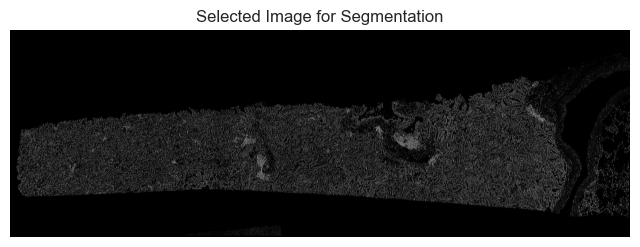

In [13]:
plt.figure(figsize=(8, 8))
plt.imshow(image_channel, cmap='gray')
plt.title('Selected Image for Segmentation')
plt.axis('off')
plt.show()


Since the original image is too big here we define a region of interest (ROI) within the larger image, focusing on a smaller area for more efficient and targeted analysis. This is particularly useful for high-resolution images where analyzing the entire field of view might be computationally intensive.

We begin by setting a scale_factor, which controls the size of the ROI as a fraction of the full image dimensions. Here, `scale_factor = 0.05` means that the ROI will cover 5% of the original image's width and height. Adjusting this factor allows flexibility in focusing on larger or smaller portions of the image, depending on the needs of the analysis.

Using `image_channel.shape`, we extract the height and width of the full image. Then, by multiplying these dimensions by `scale_factor`, we calculate the width and height of the ROI (`roi_width` and `roi_height`). Converting these values to integers ensures that they’re compatible with image indexing.

Finally, we make an optional adjustment to ensure that the ROI dimensions are even numbers, which can simplify image processing tasks. We do this by reducing `roi_width` and `roi_height` by 1 if they are odd, using modulo operations. This adjustment helps avoid issues when working with certain algorithms that may require even-numbered dimensions, ensuring that the ROI dimensions are compatible with a range of image processing techniques.

In [15]:
scale_factor = 0.05  #adjust based on the size of the img that you want to be processed
image_height, image_width = image_channel.shape

# roi
roi_width = int(image_width * scale_factor)
roi_height = int(image_height * scale_factor)
roi_width -= roi_width % 2
roi_height -= roi_height % 2

#calculate the starting and ending coordinates
x_center = image_width // 2
y_center = image_height // 2

x_start = x_center - roi_width // 2
x_end = x_center + roi_width // 2
y_start = y_center - roi_height // 2
y_end = y_center + roi_height // 2


Extract the ROI from the image

In [16]:
roi_image = image_channel[y_start:y_end, x_start:x_end]
# dimensions
print(f"ROI image shape: {roi_image.shape}")

ROI image shape: (854, 2558)


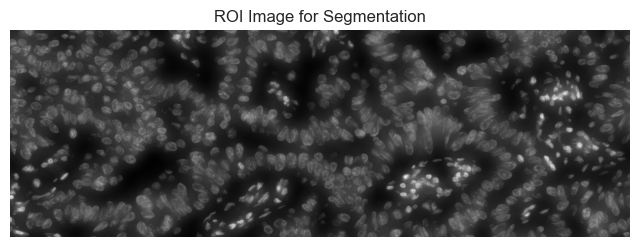

In [17]:
plt.figure(figsize=(8, 8))
plt.imshow(roi_image, cmap='gray')
plt.title('ROI Image for Segmentation')
plt.axis('off')
plt.show()

Next we map the ROI pixel coordinates back to real-world units (micrometers) and filter the spatial transcriptomics data to include only the transcripts within the ROI. This enables precise alignment of the transcript data with the selected region in the image.

We start by defining scaling factors for converting image pixels to micrometers. Here, `x_scale` and `y_scale` represent the conversion rate based on the pixel size provided in the image metadata: each micrometer contains approximately 4.7 pixels (1 / 0.2125). This conversion allows us to translate pixel coordinates into micrometer units, which are required for comparing and aligning data across different scales.

Using these scaling factors, we calculate the boundaries of the ROI in micrometers. For each dimension, `x_start`, `x_end`, `y_start`, and `y_end` (which are pixel coordinates from the original image), we divide by the scaling factor to obtain the corresponding boundaries in micrometers: `x_start_um`, `x_end_um`, `y_start_um`, and `y_end_um`. This step ensures that our ROI is defined consistently in both pixel and physical units.

Next, we filter the transcriptomics data to include only the transcripts located within the ROI. We use conditional filtering on the `x_location` and `y_location` columns of the data DataFrame, retaining only the transcripts whose coordinates fall within the calculated micrometer boundaries. The result is stored in roi_data, which represents the subset of transcripts that reside within our chosen ROI.

Finally, by printing `len(roi_data)`, we get a quick count of the transcripts within the ROI.

In [ ]:
#using the scaling factors from before
x_scale = 1 / 0.2125  # pixels per µm
y_scale = 1 / 0.2125  # pixels per µm

#roi boundaries in micrometers
x_start_um = x_start / x_scale
x_end_um = x_end / x_scale
y_start_um = y_start / y_scale
y_end_um = y_end / y_scale

#filter transcripts within the ROI boundaries
roi_data = data[
    (data['x_location'] >= x_start_um) &
    (data['x_location'] < x_end_um) &
    (data['y_location'] >= y_start_um) &
    (data['y_location'] < y_end_um)
].copy()
print(f"Number of transcripts in ROI: {len(roi_data)}")


Number of transcripts in ROI: 97422


Now we should subtract `x_start_um` from each transcript’s `x_location` and `y_start_um` from each `y_location` in `roi_data`. By doing so, we create new columns, `x_location_roi` and `y_location_roi`, that represent each transcript’s position relative to the top-left corner of the ROI rather than the full image.

In [21]:
roi_data['x_location_roi'] = roi_data['x_location'] - x_start_um
roi_data['y_location_roi'] = roi_data['y_location'] - y_start_um

Now we finally set up the Cellpose segmentation model to identify cells within the ROI. Cellpose is a versatile deep learning-based tool commonly used for cell segmentation, especially on fluorescence and cytoplasmic images. Here, we are preparing the model for use in the analysis.

First, we import the models module from the cellpose package, which provides access to pre-trained Cellpose models. Next, we initialize a model instance using `models.Cellpose()`. By setting `gpu=False`, we specify that the model will run on the CPU. This is useful if GPU resources are unavailable, though using a GPU can speed up the segmentation process if it is an option.

We also set `model_type='cyto'`, indicating that the model should use Cellpose’s pre-trained “cyto” (cytoplasm) model, which is optimized for identifying cell boundaries in images with visible cell structures. This choice is typically well-suited for images showing cell cytoplasm, though Cellpose offers other model types, like “nuclei,” if our focus were solely on nuclear segmentation.

In [22]:
from cellpose import models
model = models.Cellpose(gpu=False, model_type='cyto')

/Users/rasools/miniconda3/envs/segmentation_env/lib/python3.9/site-packages/cellpose/resnet_torch.py:280: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.lo

Then, we estimate the average cell diameter in pixels and then use Cellpose to perform cell segmentation on the ROI.

We start by setting `cell_diameter_um` to an estimated cell diameter in micrometers, which is based on biological knowledge of cell sizes in the specific tissue or sample type. Here, we use 10 micrometers as the mouse cell daimeter for mouse brains cells is estrimated 7-10 micrometers, but this value can be adjusted based on the specific dataset.

To convert this estimate into pixel units, we multiply `cell_diameter_um` by the scaling factor `x_scale` (pixels per micrometer), calculated previously. This results in `cell_diameter_pixels`, an approximation of the cell diameter in the pixel space of the image. By converting the diameter to pixels, we ensure that Cellpose can interpret the size parameter relative to the image’s resolution.

Next, we run the Cellpose model on `roi_image`, the 2D image extracted from the ROI. The model’s eval() function applies the segmentation model to the image, using `diameter=cell_diameter_pixels` to guide the segmentation scale. The channels=[0, 0] parameter specifies that the image is grayscale; both entries as 0 indicate that there is a single channel for both input and detection purposes.

The eval() function returns several outputs:

- `masks`: a labeled mask array where each detected cell has a unique identifier,
  
- `flows`: which provides information about cell boundary flows,
  
- `styles`: representing style vectors for detected objects, and
  
- `diams`: the diameter used in the model (helpful if it has been automatically adjusted).


In [23]:
cell_diameter_um = 10  # µm
cell_diameter_pixels = cell_diameter_um * x_scale
print(f"Estimated cell diameter in pixels: {cell_diameter_pixels}")
#run segmentation
masks, flows, styles, diams = model.eval(
    roi_image,
    diameter=cell_diameter_pixels,
    channels=[0, 0]
)


Estimated cell diameter in pixels: 47.05882352941177


In [24]:
print(f"Number of cells detected in ROI: {masks.max()}")

Number of cells detected in ROI: 761


Now we convert the transcript coordinates within the ROI from micrometers to pixel indices, preparing them for alignment with the segmentation mask.

First, we extract the x- and y-coordinates in micrometers from `roi_data`, which represents transcript locations relative to the top-left corner of the ROI. These coordinates are stored in `x_coords_um` and `y_coords_um`, making it easy to work directly with arrays of positions.

To map these positions into the pixel space of `roi_image`, we multiply each coordinate by the scaling factor (`x_scale` and `y_scale`) previously defined. This scaling factor converts micrometers into pixel units, allowing us to obtain `x_indices` and `y_indices` the pixel indices that match the resolution of the segmentation mask.

By converting coordinates to pixel indices, we can precisely locate each transcript in the context of the segmented cells within the ROI.

In [25]:
x_coords_um = roi_data['x_location_roi'].values
y_coords_um = roi_data['y_location_roi'].values

#pixel indices
x_indices = (x_coords_um * x_scale).astype(int)
y_indices = (y_coords_um * y_scale).astype(int)

In [27]:
#RRoi image dimensions
roi_height, roi_width = roi_image.shape

#indices
x_indices = np.clip(x_indices, 0, roi_width - 1)
y_indices = np.clip(y_indices, 0, roi_height - 1)


Next we assign each transcript to a segmented cell based on its pixel coordinates, linking gene expression data to specific cells within the ROI.

In [28]:
#cell labels for each transcript
cell_labels = masks[y_indices, x_indices]
#Add cell labels to the data
roi_data['cellpose_cell_id'] = cell_labels

#preview
print(roi_data.head())


           transcript_id     cell_id  overlaps_nucleus feature_name  \
5298560  281539401221915  dcdoepmd-1                 1         SOX2   
5298562  281539401221919  dcennfee-1                 1        MCF2L   
5298564  281539401221930  dcdoepmd-1                 1         SOX2   
5298573  281539401221974  dcejjaai-1                 0         KRT7   
5298596  281539401222054  dcendllf-1                 1          PGR   

         x_location  y_location  z_location    qv fov_name  nucleus_distance  \
5298560   5178.8020   1747.4918   19.144442  40.0      C10          0.000000   
5298562   5179.6820   1739.0795   19.792334  40.0      C10          0.000000   
5298564   5181.3604   1746.7770   21.253727  40.0      C10          0.000000   
5298573   5185.6606   1747.3582   20.520786  40.0      C10          0.169617   
5298596   5196.8843   1733.5573   19.023884  40.0      C10          0.000000   

         codeword_index  x_location_roi  y_location_roi  cellpose_cell_id  
5298560         

Keep only transcripts assigned to a cell

In [29]:
assigned_data = roi_data[roi_data['cellpose_cell_id'] > 0].copy()
print(f"Total transcripts in ROI: {len(roi_data)}")
print(f"Assigned transcripts: {len(assigned_data)}")

Total transcripts in ROI: 97422
Assigned transcripts: 47541


we visualize the results of the Cellpose segmentation overlayed on the ROI image, allowing us to inspect how well the model identified individual cells in the selected region.

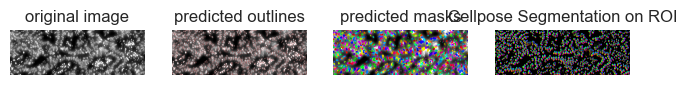

In [ ]:

fig = plt.figure(figsize=(8, 8))
plot.show_segmentation(fig, roi_image, masks, flows[0])
plt.title('Cellpose Segmentation on ROI')
plt.show()

Group by cell and gene to get expression counts

In [31]:
expression_per_cell = assigned_data.groupby(['cellpose_cell_id', 'feature_name']).size().reset_index(name='count')
expression_matrix = expression_per_cell.pivot(index='cellpose_cell_id', columns='feature_name', values='count').fillna(0)
print(expression_matrix.head())

feature_name      ABCC11  ACE2  ACKR1  ACTA2  ACTG2  ADAM28  ADAMTS1  ADGRE1  \
cellpose_cell_id                                                               
1                    0.0   0.0    0.0    0.0    0.0     0.0      0.0     0.0   
2                    0.0   0.0    0.0    0.0    1.0     0.0      0.0     0.0   
3                    0.0   0.0    0.0    0.0    0.0     0.0      0.0     0.0   
4                    0.0   1.0    0.0    0.0    0.0     0.0      0.0     0.0   
5                    0.0   0.0    0.0    0.0    0.0     0.0      0.0     0.0   

feature_name      ADGRL4  ADH1C  ...  UnassignedCodeword_0473  \
cellpose_cell_id                 ...                            
1                    0.0    0.0  ...                      0.0   
2                    0.0    0.0  ...                      0.0   
3                    0.0    0.0  ...                      0.0   
4                    0.0    0.0  ...                      0.0   
5                    0.0    0.0  ...             

we can plot the locations of transcripts overlaid on the ROI image, specifically highlighting those that have been assigned to segmented cells. This helps us see how transcript data aligns with the detected cell boundaries within the region.

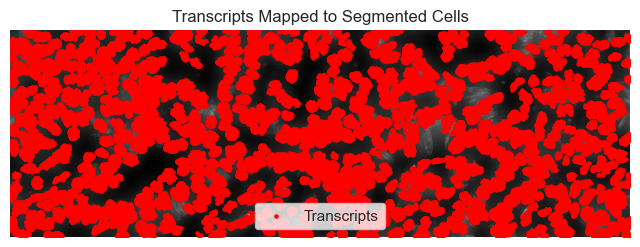

In [32]:
plt.figure(figsize=(8, 8))
plt.imshow(roi_image, cmap='gray')
plt.scatter(
    x_indices[roi_data['cellpose_cell_id'] > 0],
    y_indices[roi_data['cellpose_cell_id'] > 0],
    c='red', s=5, label='Transcripts'
)
plt.title('Transcripts Mapped to Segmented Cells')
plt.axis('off')
plt.legend()
plt.show()

Finally, we can visualize the expression of a specific gene across the detected cells, providing insights into the spatial distribution of gene expression within the ROI. This visualization can reveal patterns of gene expression, such as high expression in specific cell types or regions, helping to interpret the biological significance of the data.

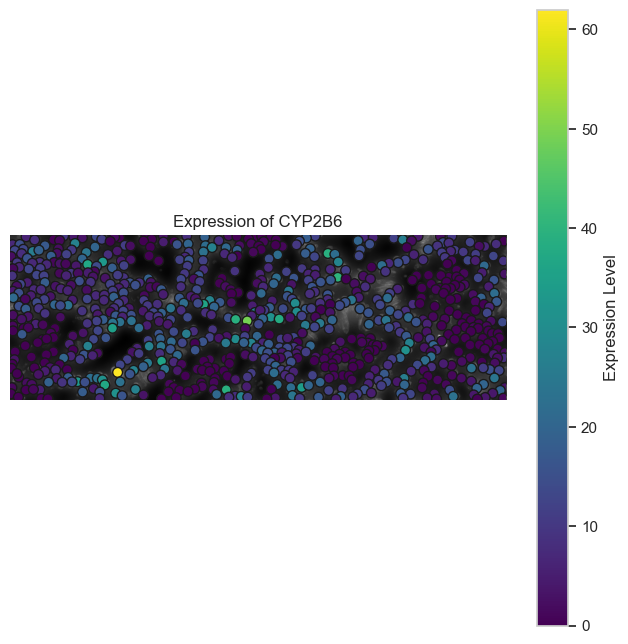

In [34]:
gene_of_interest = 'CYP2B6'

if gene_of_interest in expression_matrix.columns:
    cell_ids = expression_matrix.index.values
    expression_values = expression_matrix[gene_of_interest].values

    # Get centroids of cells
    from skimage.measure import regionprops
    properties = regionprops(masks)
    centroids = np.array([prop.centroid for prop in properties])
    cell_labels = np.array([prop.label for prop in properties])

    # Create a mapping from cell label to centroid
    centroid_dict = {label: centroid for label, centroid in zip(cell_labels, centroids)}

    # Get centroids for the cells in expression_matrix
    cell_centroids = np.array([centroid_dict.get(cell_id, (np.nan, np.nan)) for cell_id in cell_ids])

    # Plot
    plt.figure(figsize=(8, 8))
    plt.imshow(roi_image, cmap='gray')
    plt.scatter(
        cell_centroids[:, 1],  # x-coordinates
        cell_centroids[:, 0],  # y-coordinates
        c=expression_values,
        cmap='viridis',
        s=50,
        edgecolors='k',
        label=f'Expression of {gene_of_interest}'
    )
    plt.title(f'Expression of {gene_of_interest}')
    plt.axis('off')
    plt.colorbar(label='Expression Level')
    plt.show()
else:
    print(f"{gene_of_interest} not found in expression matrix.")


now we want to compare the cellpose segmentation with 10x segmentation, we can use the Jaccard index to quantify the similarity between the two segmentation masks. The Jaccard index, also known as the intersection-over-union (IoU), measures the overlap between two sets by dividing the size of their intersection by the size of their union. In the context of segmentation masks, the Jaccard index provides a measure of how well two masks align, with values closer to 1 indicating greater similarity.

In [ ]:
cells_data_path = 'data/xenium_2.0.0_io/cells.csv'
cells_data = pd.read_csv(cells_data_path)
print(cells_data.head())

      cell_id  x_centroid   y_centroid  transcript_counts  \
0  aaaadpbp-1  206.089813  1495.898193                  0   
1  aaaaficg-1  201.765823  1816.210815                 19   
2  aaabbaka-1  179.024506  2167.253906                 53   
3  aaabbjoo-1  186.060654  2163.309082                 29   
4  aaablchg-1  200.246887  2198.593506                 42   

   control_probe_counts  control_codeword_counts  unassigned_codeword_counts  \
0                     0                        0                           0   
1                     0                        0                           0   
2                     0                        0                           0   
3                     0                        0                           0   
4                     0                        0                           1   

   deprecated_codeword_counts  total_counts   cell_area  nucleus_area  
0                           0             0   68.456877           NaN  
1       

In [ ]:
cell_boundaries_path = 'data/xenium_2.0.0_io/cell_boundaries.csv.gz'  # Adjust the path as needed
cell_boundaries = pd.read_csv(cell_boundaries_path)
print(cell_boundaries.head())

      cell_id   vertex_x   vertex_y
0  aaaadpbp-1  205.06250  1489.8375
1  aaaadpbp-1  204.21251  1490.4751
2  aaaadpbp-1  204.00000  1491.1125
3  aaaadpbp-1  202.08751  1493.4501
4  aaaadpbp-1  201.87500  1494.7251


First we need to extract the region of intrest from the 10x segmentation mask, then we need to resize the 10x segmentation mask to the same size as the cellpose segmentation mask, then we can calculate the Jaccard index between the two masks.

In [ ]:
scale_factor = 0.05
image_height, image_width = image_channel.shape
roi_width = int(image_width * scale_factor)
roi_height = int(image_height * scale_factor)

roi_width -= roi_width % 2
roi_height -= roi_height % 2

x_center = image_width // 2
y_center = image_height // 2

x_start = x_center - roi_width // 2
x_end = x_center + roi_width // 2
y_start = y_center - roi_height // 2
y_end = y_center + roi_height // 2

#cnvert pixel coordinates to micrometers
x_scale = 1 / 0.2125  
y_scale = 1 / 0.2125

x_start_um = x_start / x_scale
x_end_um = x_end / x_scale
y_start_um = y_start / y_scale
y_end_um = y_end / y_scale


Filter cells whose centroids are within the ROI 

In [40]:
cells_in_roi = cells_data[
    (cells_data['x_centroid'] >= x_start_um) &
    (cells_data['x_centroid'] < x_end_um) &
    (cells_data['y_centroid'] >= y_start_um) &
    (cells_data['y_centroid'] < y_end_um)
].copy()

print(f"Number of cells in ROI from original segmentation: {len(cells_in_roi)}")


Number of cells in ROI from original segmentation: 987


Filter cell boundaries for cells in ROI

In [43]:
cell_boundaries_in_roi = cell_boundaries[cell_boundaries['cell_id'].isin(cells_in_roi['cell_id'])].copy()
cell_polygons = {}
for cell_id, group in cell_boundaries_in_roi.groupby('cell_id'):
    x_coords = group['vertex_x'].values
    y_coords = group['vertex_y'].values
    coords = list(zip(x_coords, y_coords))
    try:
        polygon = Polygon(coords)
        if not polygon.is_valid:
            # Attempt to fix invalid polygons
            polygon = polygon.buffer(0)
        cell_polygons[cell_id] = polygon
    except TopologicalError as e:
        print(f"Could not create polygon for cell {cell_id}: {e}")


In [45]:
# Function to transform geometries to pixel coordinates
def geometry_to_pixel_coords(geometry):
    # Shift geometry to ROI coordinates (subtract ROI origin in micrometers)
    geometry_shifted = translate(geometry, xoff=-x_start_um, yoff=-y_start_um)
    # Scale geometry from micrometers to pixels
    geometry_scaled = scale(geometry_shifted, xfact=x_scale, yfact=y_scale, origin=(0, 0))
    return geometry_scaled

# Apply transformation to all cell polygons
cell_polygons_px = {cell_id: geometry_to_pixel_coords(geom) for cell_id, geom in cell_polygons.items()}


Map cell_id strings to integer labels

In [46]:
cell_id_to_label = {cell_id: idx+1 for idx, cell_id in enumerate(cell_polygons_px.keys())}
label_to_cell_id = {idx+1: cell_id for idx, cell_id in enumerate(cell_polygons_px.keys())}

Prepare shapes for rasterization

In [47]:
shapes = [
    (geom, cell_id_to_label[cell_id])
    for cell_id, geom in cell_polygons_px.items()
]

Create an empty mask and rasterize the shapes

In [49]:
original_masks = np.zeros_like(roi_image, dtype=np.uint16)
original_masks = features.rasterize(
    shapes,
    out_shape=original_masks.shape,
    fill=0,
    all_touched=True,
    dtype=np.uint16
)


Lets compare the cellpose segmentation with 10x segmentation side by side

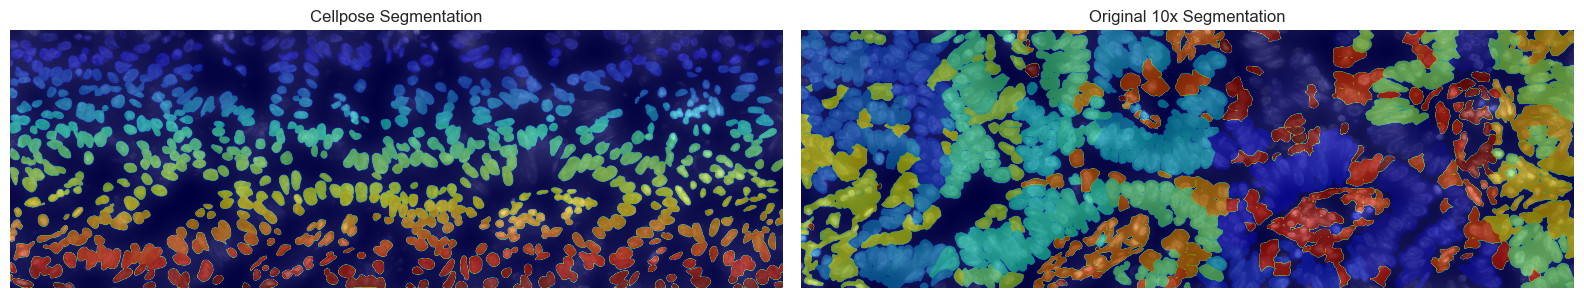

In [51]:
plt.figure(figsize=(16, 8))

#Cellpose 
plt.subplot(1, 2, 1)
plt.imshow(roi_image, cmap='gray')
plt.imshow(masks, alpha=0.5, cmap='jet')
plt.title('Cellpose Segmentation')
plt.axis('off')

#Original 
plt.subplot(1, 2, 2)
plt.imshow(roi_image, cmap='gray')
plt.imshow(original_masks, alpha=0.5, cmap='jet')
plt.title('Original 10x Segmentation')
plt.axis('off')

plt.tight_layout()
plt.show()


And we can overlay the cellpose segmentation on the 10x segmentation to see how well they align

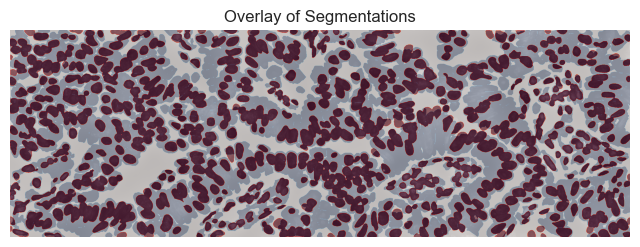

In [52]:
# Overlay both masks
plt.figure(figsize=(8, 8))
plt.imshow(roi_image, cmap='gray')
plt.imshow((original_masks > 0).astype(int), cmap='Blues', alpha=0.5, label='Original')
plt.imshow((masks > 0).astype(int), cmap='Reds', alpha=0.5, label='Cellpose')
plt.title('Overlay of Segmentations')
plt.axis('off')
plt.show()


In [53]:
# Convert masks to binary masks (cells vs background)
cellpose_mask_binary = (masks > 0).astype(int)
original_mask_binary = (original_masks > 0).astype(int)

# Flatten the masks for metric computation
cellpose_mask_flat = cellpose_mask_binary.flatten()
original_mask_flat = original_mask_binary.flatten()


In [ ]:

jaccard = jaccard_score(original_mask_flat, cellpose_mask_flat)
print(f'Jaccard Index: {jaccard:.4f}')


Jaccard Index: 0.4733


In [56]:
def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    sum_union = np.sum(y_true) + np.sum(y_pred)
    dice = 2 * intersection / sum_union
    return dice

dice = dice_coefficient(original_mask_flat, cellpose_mask_flat)
print(f'Dice Coefficient: {dice:.4f}')

Dice Coefficient: 0.6425


In [57]:
cellpose_cell_count = masks.max()
original_cell_count = original_masks.max()

print(f"Number of cells detected by Cellpose: {cellpose_cell_count}")
print(f"Number of cells in original segmentation: {original_cell_count}")


Number of cells detected by Cellpose: 761
Number of cells in original segmentation: 987


In [59]:
# Cellpose cell areas
cellpose_props = regionprops_table(masks, properties=['area'])
cellpose_areas = pd.DataFrame(cellpose_props)
cellpose_areas['method'] = 'Cellpose'

# Original cell areas
original_props = regionprops_table(original_masks, properties=['area'])
original_areas = pd.DataFrame(original_props)
original_areas['method'] = 'Original'

# Combine data
areas_df = pd.concat([cellpose_areas, original_areas], ignore_index=True)


compare cell sizes between the two segmentation methods


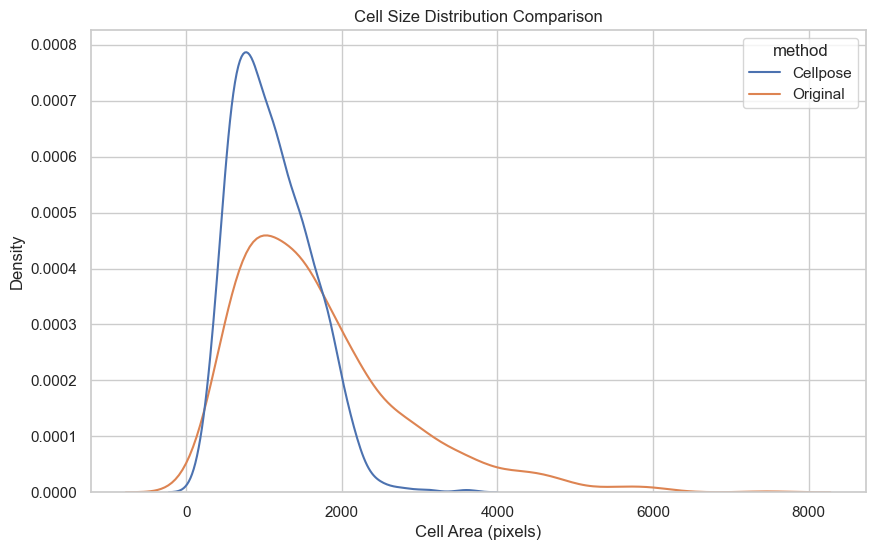

In [60]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=areas_df, x='area', hue='method', common_norm=False)
plt.xlabel('Cell Area (pixels)')
plt.ylabel('Density')
plt.title('Cell Size Distribution Comparison')
plt.show()

and save the results to a new file

In [61]:
tifffile.imwrite('data/xenium_2.0.0_io/cellpose/cellpose_masks_roi.tif', masks.astype(np.uint16))
tifffile.imwrite('data/xenium_2.0.0_io/cellpose/original_masks_roi.tif', original_masks.astype(np.uint16))

In [62]:
metrics = pd.DataFrame({
    'Metric': ['Jaccard Index', 'Dice Coefficient'],
    'Value': [jaccard, dice]
})
metrics.to_csv('data/xenium_2.0.0_io/cellpose/segmentation_comparison_metrics.csv', index=False)


In [63]:
areas_df.to_csv('data/xenium_2.0.0_io/cellpose/cell_size_comparison.csv', index=False)